<a href="https://colab.research.google.com/github/aarongraybill/Math210/blob/main/ProblemSets/Midterm2/Midterm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Math 210
## Aaron Graybill
### Midterm 2
### 4/30/21


## Imports


In [2]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import itertools

In [3]:
def print_tableau(a,indep_names,dep_names,indep_names_dual,dep_names_dual):
#
# Given matrix "a" and lists of variables names "indep_names" and "dep_names",
#   and (for the dual) "indep_names_dual" and "dep_names_dual",
# this function prints the matrix and labels in standard tableau format
# (including adding the -1, the minus signs in the last column, and labeling the lower-right as obj)
#
# First, check the inputs: indep_names and dep_names_dual should be one shorter than the number of columns of A
#                          dep_names and indep_names_dual should be one shorter than the number of rows of A
#
    nrows = a.shape[0]    # use the shape function to determine number of rows and cols in A
    ncols = a.shape[1]
    nindep = len(indep_names)
    nindep_dual = len(indep_names_dual)
    ndep = len(dep_names)
    ndep_dual = len(dep_names_dual)
    if nindep != ncols-1:
        print("WARNING: # of indep vbles should be one fewer than # columns of matrix")
    if ndep != nrows-1:
        print("WARNING: # of dep vbles should be one fewer than # rows of matrix")
    if nindep_dual != nrows-1:
        print("WARNING: # of indep dual vbles should be one fewer than # rows of matrix")
    if ndep_dual != ncols-1:
        print("WARNING: # of dep dual vbles should be one fewer than # columns of matrix")
# Now do the printing (uses a variety of formatting techniques in Python)     
    print("          ",end="")       # On first line, leave blank space so we can fit in dual labels lower down 
    for j in range(ncols-1):                    # Print the independent variables in the first row
        print(indep_names[j].rjust(10),end="")  # rjust(10) makes fields 10 wide and right-justifies;
                                                #    the end command prevents newline)
    print("        -1")                         # Tack on the -1 at the end of the first row
    for i in range(nrows-1):
        print(indep_names_dual[i].rjust(10),end="")
        for j in range(ncols):                  # Print all but the last row of the matrix
                print("%10.3f" % a[i][j],end="") # The syntax prints in a field 10 wide, showing 3 decimal points
        lab = "= -" + dep_names[i]
        print(lab.rjust(10))
    print("        -1",end="")
    for j in range(ncols):
        print("%10.3f" % a[nrows-1][j],end="")  # Print the last row of the matrix, with label "obj" at end
    lab = "= obj"
    print(lab.rjust(10))
    print("          ",end="")
    for j in range(ncols-1):
        lab = "=" + dep_names_dual[j]
        print(lab.rjust(10),end="")
    print("  =dualobj")
    print(" ")    # Put blank line at bottom

In [4]:
def pivot(a,pivrow,pivcol,indep_names,dep_names,indep_names_dual,dep_names_dual) :
# 
# Given matrix "a", a row number "pivrow" and column number "pivcol", 
#  and lists of variable names "indep_names" and "dep_names", this
#  function does three things:
#    (1) outputs the new version of the matrix after a pivot,
#    (2) updates the lists of variable names post-pivot
#    (3) prints the new matrix, including labels showing the variable names
#
# First, check the inputs: indep_names should be one shorter than the number of columns of A
#                          dep_names should be one shorter than the number of rows of A
#                          you should not be pivoting on the last row or last column
#
    nrows = a.shape[0]    # use the shape function to determine number of rows and cols in A
    ncols = a.shape[1]
    nindep = len(indep_names)
    nindep_dual = len(indep_names_dual)
    ndep = len(dep_names)
    ndep_dual = len(dep_names_dual)
    if nindep != ncols-1:
        print("WARNING: # of indep vbles should be one fewer than # columns of matrix")
    if ndep != nrows-1:
        print("WARNING: # of dep vbles should be one fewer than # rows of matrix")
    if nindep_dual != nrows-1:
        print("WARNING: # of indep dual vbles should be one fewer than # rows of matrix")
    if ndep_dual != ncols-1:
        print("WARNING: # of dep dual vbles should be one fewer than # columns of matrix")
    if pivrow > nrows-1 or pivcol > ncols-1:
        print("WARNING: should not pivot on last row or column")
    newa = a.copy()       # make a copy of A, to be filled in below with result of pivot
    p = a[pivrow-1][pivcol-1]   # identify pivot element
    newa[pivrow-1][pivcol-1] = 1/p   # set new value of pivot element
    # Set entries in p's row
    for j in range(ncols):
        if j != pivcol-1:
            newa[pivrow-1][j]=a[pivrow-1][j]/p;
    # Set entries in p's column
    for i in range(nrows):
        if i != pivrow-1:
            newa[i][pivcol-1]=-a[i][pivcol-1]/p;
    # Set all other entries
    for i in range(nrows):
        for j in range(ncols):
            if i != pivrow-1 and j != pivcol-1:
                r = a[i][pivcol-1]
                q = a[pivrow-1][j]
                s = a[i][j]
                newa[i][j]=(p*s-q*r)/p
    # Now transfer the new tableau into a
    for i in range(nrows) :
        for j in range(ncols) :
            a[i][j] = newa[i][j]
    # Now swap the variable names
    temp = indep_names[pivcol-1]
    indep_names[pivcol-1]=dep_names[pivrow-1]
    dep_names[pivrow-1]=temp
    temp = indep_names_dual[pivrow-1]
    indep_names_dual[pivrow-1]=dep_names_dual[pivcol-1]
    dep_names_dual[pivcol-1]=temp
    print_tableau(newa,indep_names,dep_names,indep_names_dual,dep_names_dual) # Print the matrix with updated labels
    return 0;

In [5]:
def column_delete(a,col_to_remove,indep_names,dep_names,indep_names_dual,dep_names_dual) :
    import numpy as np
    anew = np.delete(a,col_to_remove-1,axis=1)
    del indep_names[col_to_remove-1]
    del dep_names_dual[col_to_remove-1]
    print_tableau(anew,indep_names,dep_names,indep_names_dual,dep_names_dual)
    return anew

In [6]:
def row_delete(a,row_to_remove,indep_names,dep_names,indep_names_dual,dep_names_dual) :
    import numpy as np
    anew = np.delete(a,row_to_remove-1,axis=0)
    del dep_names[row_to_remove-1]
    del indep_names_dual[row_to_remove-1]
    print_tableau(anew,indep_names,dep_names,indep_names_dual,dep_names_dual)
    return anew

In [7]:
def target(a) :
    nrows = a.shape[0]    # use the shape function to determine number of rows and cols in "a"
    ncols = a.shape[1]
    import numpy as np
    v = np.empty(ncols-1)
    for i in range(ncols-1):
        v[i]=a[nrows-1,i]
    biggest_c = np.max(v)
    where_is_biggest_c = np.argmax(v)+1
    if biggest_c > 0 :
        return where_is_biggest_c
    else :
        return -1

In [8]:
def select(a,pivcolnum) :
    nrows = a.shape[0]    # use the shape function to determine number of rows and cols in A
    ncols = a.shape[1]
# First task: work down the column and record the b/a ratios in a vector v
#     except record -1 if a is negative or zero
    import numpy as np
    v = np.zeros(nrows-1)
    for i in range(nrows-1):
        if a[i,pivcolnum-1]>0 :
            v[i] = a[i,ncols-1]/a[i,pivcolnum-1]
        else :
            v[i] = -1
# Second task: if max b/a > -1, find min b/a by hand (ignoring zero entries in v)
    if np.max(v) > -1 :  
        min_so_far = np.max(v)+1  # Initialize min to be for-sure bigger than the min
        for i in range(nrows-1):
            if v[i] > -1 and v[i] < min_so_far :
                min_so_far = v[i]
                where_is_min = i+1   # Add 1 to use human numbering
        return where_is_min      # Once we've scanned v for min, we can return result
            
    else :          # Otherwise, we find the m
        return -1

In [9]:
def simplexbf(a,indep_names,dep_names,dual_indep_names,dual_dep_names):
# Run the simplexbf algorithm
# Inputs: np.array "a" (assumed to be basic feasible)
#         lists of variable names indep_names and dep_names (pivot will catch if they're wrong size)
# Output: -1 if we stop because problem is unbounded, 0 if we continue to a solution
#         -9 if we take too many steps
    nrows = a.shape[0]    # use shape to find # of rows and cols in A
    ncols = a.shape[1]
    print("Starting SimplexBF (will do nothing if solution can already be determined)")
    pivcol = target(a)
    nsteps = 0
    while pivcol > -1 and nsteps < 50:  # Repeat until either solution found or 50 pivots completed
        pivrow = select(a,pivcol)
        if pivrow == -1 :
            return -1    # If select reports -1, problem is unbounded, so exit this function
        else :
            pivot(a,pivrow,pivcol,indep_names,dep_names,dual_indep_names,dual_dep_names)
            nsteps=nsteps+1
            pivcol = target(a)
    if nsteps >= 50:
        return -9    # we took too many pivots
    else:
        return 0

In [10]:
def targetnbf(a):
    nrows = a.shape[0]
    ncols = a.shape[1]
    import numpy as np
    checkrow = nrows-2
    while a[checkrow,ncols-1] >= -0.00000001 :
        if checkrow == 0 :   # if still in the "while" and at the top,
            return -1        # all the b's were >= 0, so return -1
        else :
            checkrow = checkrow-1
    return checkrow+1    # if we exit the "while", we found a negative
#                            b, so return current row # (in human numbering)

In [11]:
def selectnbf(a,targetrow) :
#  Given inputs "a" (tableau as an np.array, numbers only, no labels) 
#       and "targetrow" (a row that has a negative b; start-at-1 numbering assumed),
#  computes a pivot that could be chosen by SimplexNBF and 
#  outputs "pivrow" and "pivcol", the row and column (start-at-1 numbering) of that pivot
#  If the targeted row has no negative aij, returns -2 for both pivrow and pivcol
    nrows = a.shape[0]
    ncols = a.shape[1]
    import numpy as np
    targetrow = targetrow-1   # convert to start-at-0
    pivcol = ncols-2     # column index of last aij
    while a[targetrow,pivcol] >= 0 :
        if pivcol == 0 :   # if pivcol makes it to zero, all aij
            return [-2,-2]   # in this row were >= 0, so problem infeasible
        else :
            pivcol = pivcol-1
    minsofar = a[targetrow,ncols-1]/a[targetrow,pivcol] # we found a negative aij
    pivrow = targetrow     
    for i in range(targetrow+1,nrows-2):   # now check below it for a smaller bi/aij with aij>0
        if a[i,pivcol]>0 and a[i,ncols-1]/a[i,pivcol] < minsofar :
            minsofar = a[i,ncols-1]/a[i,pivcol]
            pivrow = i
    return [pivrow+1,pivcol+1]   # Return result (shifted to start-at-1 numbering)

In [12]:
def simplexnbf(a,indep_names,dep_names,dual_indep_names,dual_dep_names):
# Run the simplexnbf algorithm
# Inputs: np.array "a" 
#         lists of variable names indep_names and dep_names (pivot will catch if they're wrong size)
# Output: -2 if we stop because problem is infeasible, 0 if we stop at a basic feasible tableau
#.        -9 if we take too many pivots
#    (Also, the tableau "a" and variable-lists are updated with each pivot)
    nrows = a.shape[0]   
    ncols = a.shape[1]
    print("Starting SimplexNBF (will do nothing if already basic feasible)")
    nsteps = 0
    targetrow = targetnbf(a)
    while targetrow > -1 and nsteps < 50:  # Repeat until either basic feasible tableau produced or 50 pivots completed
        [pivrow,pivcol] = selectnbf(a,targetrow)
        if pivrow == -2 :
            return -2    # If selectnbf reports -2, problem is infeasible, so exit this function
        else :
            pivot(a,pivrow,pivcol,indep_names,dep_names,dual_indep_names,dual_dep_names)
            nsteps=nsteps+1
            targetrow = targetnbf(a)
    if nsteps >= 50:
        return -9    # took too many pivots
    else:
        return 0

In [13]:
def simplex(a,indep_names,dep_names,dual_indep_names,dual_dep_names) :
# Runs the simplex algorithm (doing NBF if needed, then BF)
# Inputs: np.array "a" 
#         lists of variable names indep_names and dep_names (pivot will catch if they're wrong size)
# Output: -2 if problem is infeasible
#         -1 if problem is unbounded
#         0 if problem has a solution
#    (Also, the tableau "a" and variable-lists are updated with each pivot)
    nrows = a.shape[0]   
    ncols = a.shape[1]
    print("Initial tableau")
    print_tableau(a,indep_names,dep_names,dual_indep_names,dual_dep_names)
    code = simplexnbf(a,indep_names,dep_names,dual_indep_names,dual_dep_names)
    if code == -2 :
        print("Problem is infeasible")
        return -2
    elif code == -9 : 
        print("SimplexNBF took too many pivots")
    else :
        code = simplexbf(a,indep_names,dep_names,dual_indep_names,dual_dep_names)
        if code == -1 :
            print("Problem is unbounded")
            return -1
        elif code == -9 :
            print("SimplexBF took too many pivots")
        else :
            print("Problem has solution, final tableau is shown above")
            return 0

In [14]:
def simplexeq(a,k,indep_names,dep_names,dual_indep_names,dual_dep_names) :
# Specialized function to do the "pre-simplex" step to handle tableaus where the
#   first k rows correspond to equality constraints.
    nrows = a.shape[0]   
    ncols = a.shape[1]
    print_tableau(a,indep_names,dep_names,dual_indep_names,dual_dep_names)
    for i in range(k) :
        j=0
        pivcol=-1
        for j in range(ncols-1) :
            if abs(a[i,j]) > 0.000001 :
                pivrow=i+1
                pivcol=j+1
                break
        if pivcol == -1 :
            return -3
        else :
            pivot(a,pivrow,pivcol,indep_names,dep_names,dual_indep_names,dual_dep_names)
            a=column_delete(a,pivcol,indep_names,dep_names,dual_indep_names,dual_dep_names)
            ncols=ncols-1
    code = simplex(a,indep_names,dep_names,dual_indep_names,dual_dep_names)
    return code  

## Problem 1.


### a.
This problem asks for a standard implementation of simplex with equality constraints.

The first two constraints are as given and the only other constraints are non-negativity.

We maximize the given expression resulting in the following tableau:

In [24]:
a=np.array([[1,1,1,1,1,1,22],
            [1,-2,3,-4,5,-6,0],
            [2,3,5,7,11,13,0]])
indep_names=["x1","x2","x3","x4","x5","x6"]
dep_names=["0","0"]
indep_names_dual=["y1","y2"]
dep_names_dual=["s1","s2","s3","s4","s5","s6"]
print_tableau(a,indep_names,dep_names,indep_names_dual,dep_names_dual)

                  x1        x2        x3        x4        x5        x6        -1
        y1     1.000     1.000     1.000     1.000     1.000     1.000    22.000      = -0
        y2     1.000    -2.000     3.000    -4.000     5.000    -6.000     0.000      = -0
        -1     2.000     3.000     5.000     7.000    11.000    13.000     0.000     = obj
                 =s1       =s2       =s3       =s4       =s5       =s6  =dualobj
 


In [25]:
simplexeq(a,2,indep_names,dep_names,indep_names_dual,dep_names_dual)

                  x1        x2        x3        x4        x5        x6        -1
        y1     1.000     1.000     1.000     1.000     1.000     1.000    22.000      = -0
        y2     1.000    -2.000     3.000    -4.000     5.000    -6.000     0.000      = -0
        -1     2.000     3.000     5.000     7.000    11.000    13.000     0.000     = obj
                 =s1       =s2       =s3       =s4       =s5       =s6  =dualobj
 
                   0        x2        x3        x4        x5        x6        -1
        s1     1.000     1.000     1.000     1.000     1.000     1.000    22.000     = -x1
        y2    -1.000    -3.000     2.000    -5.000     4.000    -7.000   -22.000      = -0
        -1    -2.000     1.000     3.000     5.000     9.000    11.000   -44.000     = obj
                 =y1       =s2       =s3       =s4       =s5       =s6  =dualobj
 
                  x2        x3        x4        x5        x6        -1
        s1     1.000     1.000     1.000     1.000     

0

## Problem 2.

I solve the problem in two ways (just to check myself) and I get two different allocations, but they both result in a maximum flow of 10. The second method uses the code that I wrote for pset 7.

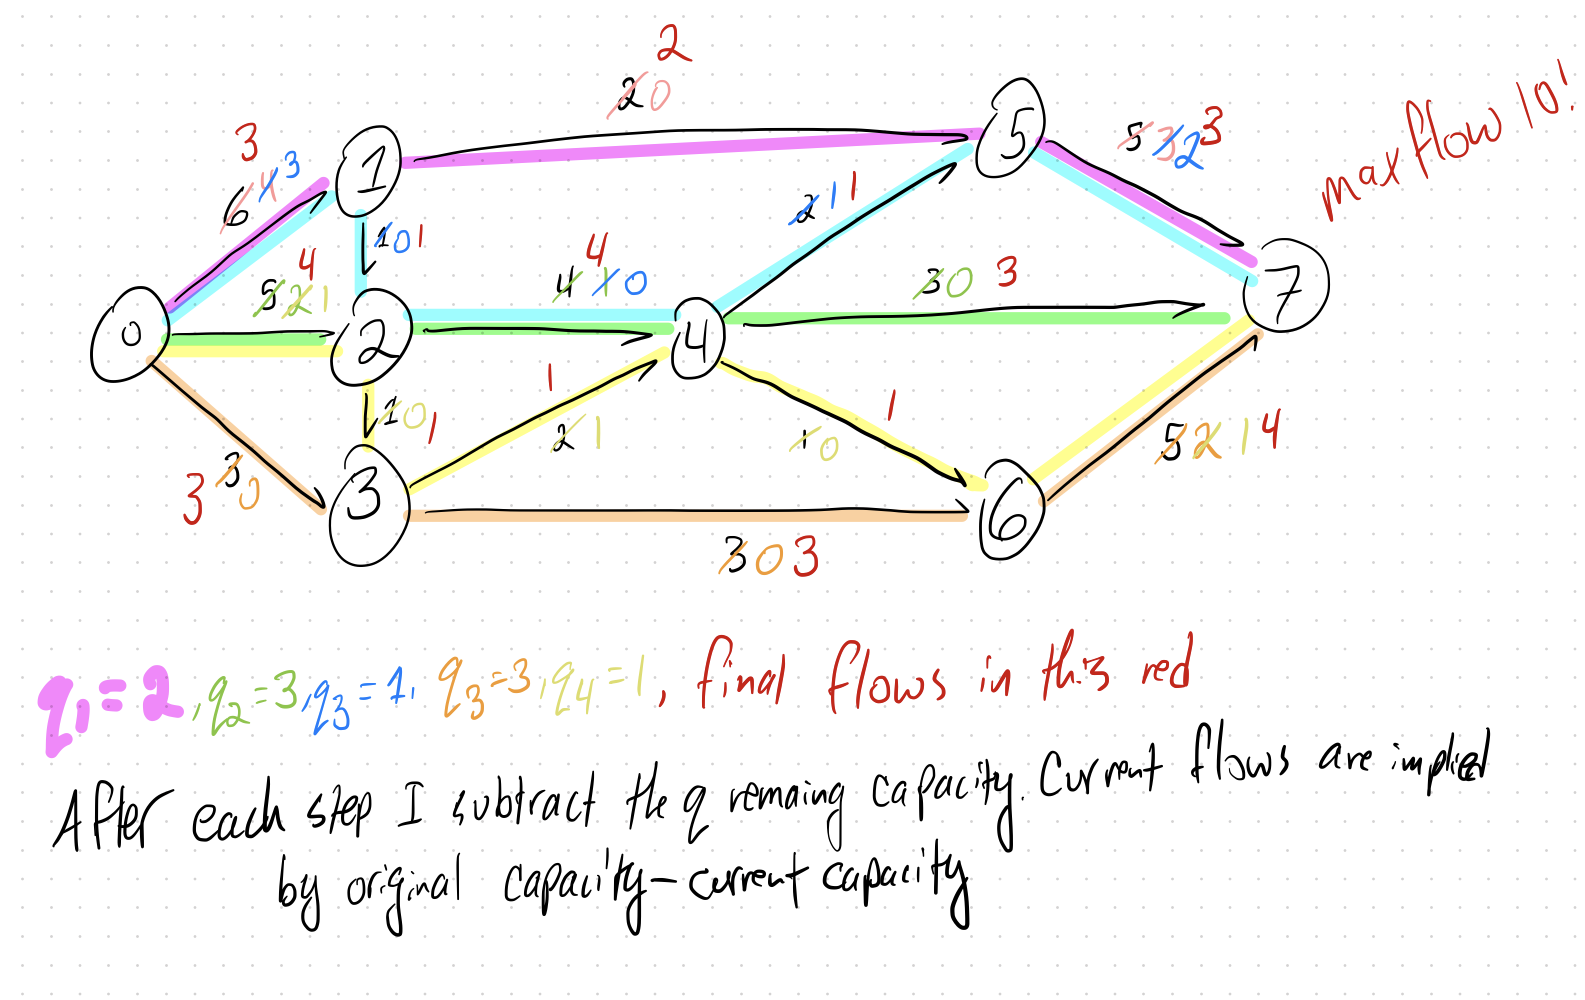

In [42]:
edge_mat_1=np.transpose(
    np.array( [
              [0,0,0,1,1,2,2,3,3,4,4,4,5,6],
              [1,2,3,2,5,3,4,4,6,5,6,7,7,7],
              [6,5,3,1,2,1,4,2,3,2,1,3,5,5]]))

In [39]:
#used to make label names:
  #source: geeksforgeeks.org/python-insert-the-string-at-the-beginning-of-all-items-in-a-list/
def prepend(list, str):   
    
  # Using '% s'
  str += '% s'
  list =  [str % i for i in list]
  return(list)

In [34]:
import itertools
import pandas

def create_eq_matrix(nvert,edgemat):

  A=np.zeros((nvert,(nvert**2)))  #too large will shrink later, 
                                  #but makes for easy indexing
  c=np.zeros(nvert**2) # ditto

  #loop over the edgemat, taking each path as an iterand
  for count, value in enumerate(edgemat[:,0:2]):

    col_num=(nvert)*(value[0])+(value[1]) # n columns from each vertex

    if (value[0]==0): #coming from source
      #Don't have to worry about constraint on sources
      A[value[1],col_num]=1
    elif (value[1]==(nvert-1)): #going to sink
      #dont have to worry about constraint on sink
      A[value[0],col_num]=-1
      c[col_num]=-1#Hey this is an important column, but it in the objective
    else: #intermediate
      A[value[1],col_num]=1
      A[value[0],col_num]=-1
  
  A=np.append(A,np.array([c]),axis=0) #add the row of cs

  #Name appropriately
  col_names=[] #create vector of names
  for i in itertools.product(np.arange(nvert),repeat=2): #all combos of indexes
    col_names += [str(i[0])+","+str(i[1])]
  row_names=prepend(np.arange(nvert),"V")
  row_names+="c" #add one final row name

  A=pd.DataFrame(A,index=row_names,columns=col_names)# put things into pd data

  # Remove unused rows and columns
  A=A.loc[(A != 0).any(axis=1), (A != 0).any(axis=0)]

  #separate A and c again
  c=A.iloc[-1:,:]
  A=A.iloc[:-1,:]

  #create easy matrices and vectors
  b_eq=np.zeros(A.shape[0])
  A_leq=np.identity(edgemat.shape[0])
  b_leq=edgemat[:,2]

  #do optimization
  optimal=linprog(c,A_eq=A,A_ub=A_leq,b_eq=b_eq,b_ub=b_leq,method="simplex")
  flows=np.array(np.array([optimal.x]))

  #generateoutput
  summary=pd.DataFrame(flows,index=["flow"],columns=A.columns)
  max="The maximum is: " +str(-optimal.fun)

  #print output and return
  print(max)
  return (summary,A)

In [43]:
create_eq_matrix(8,edge_mat_1)[0]

The maximum is: 10.0


,"0,1","0,2","0,3","1,2","1,5","2,3","2,4","3,4","3,6","4,5","4,6","4,7","5,7","6,7"
flow,3.0,4.0,3.0,1.0,2.0,1.0,4.0,1.0,3.0,2.0,1.0,2.0,4.0,4.0
